In [ ]:
"""
File Loading and Mask Processing Function
=======================================

This function loads nd2 files and their corresponding probability masks from the Data folder structure.

Directory Structure:
-----------------
base_path/
└── Data/
    ├── [nd2 files]
    └── Processed/
        ├── C3/
        │   └── [phase masks]
        ├── C1/
        │   └── [c1 masks]
        └── C2/
            └── [c2 masks]

File Naming Convention:
--------------------
- ND2 files: example.nd2
- Phase masks: example_C3_Probabilities.tif
- C2 masks: example_C1_Probabilities.tif
- F3 masks: example_C2_Probabilities.tif

Returns:
-------
The function returns a tuple containing:
1. nd2_list: List of loaded nd2 image data
2. mask_C1: List of C1 masks
3. mask_C2: List of C2 masks
4. labeled_mask_phase: List of processed phase masks
5. position_list: List of position information
6. marker_list: List of marker colors
7. physical_size: Tuple of physical dimensions
8. delta_t: Tuple of time information

To unpack the results:
(nd2_list, mask_C1, mask_f3, labeled_mask_phase,
 position_list, marker_list, physical_size, delta_t) = results
"""
print()

In [ ]:
import os

from FliI_notebook_utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:

# Get the current working directory to help with debugging
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Check if the directories exist
base_dir = '/Users/rosaeinenkel/Desktop/FliI_Analysis/Data'
print(f"Checking if base directory exists: {os.path.exists(base_dir)}")
print(f"Checking if C1 directory exists: {os.path.exists(os.path.join(base_dir, 'Processed', 'C1'))}")
print(f"Checking if C3 directory exists: {os.path.exists(os.path.join(base_dir, 'Processed', 'C3'))}")
print(f"Checking if C2 directory exists: {os.path.exists(os.path.join(base_dir, 'Processed', 'C2'))}")

# Try with explicit paths
cell_seg_prob = 0.8
foci_seg_prob = 0.8

# Use absolute paths or ensure relative paths are correct
(nd2_list, mask_C1, mask_C3, labeled_mask_phase,
 position_list, marker_list, physical_size, delta_t) = load_matched_files(
    base_path=os.path.abspath(base_dir),
    cell_mask_path=os.path.abspath(os.path.join(base_dir, 'Processed', 'C3')),
    foci1_path=os.path.abspath(os.path.join(base_dir, 'Processed', 'C1')),
    foci2_path=os.path.abspath(os.path.join(base_dir, 'Processed', 'C2')),
    seg_prob=cell_seg_prob,
    max_prob=foci_seg_prob
)

Current working directory: /Users/rosaeinenkel/Desktop/FliI_Analysis
Checking if base directory exists: True
Checking if C1 directory exists: True
Checking if C3 directory exists: True
Checking if C2 directory exists: True
Using paths:
Data path: /Users/rosaeinenkel/Desktop/FliI_Analysis/Data/
Cell mask path: /Users/rosaeinenkel/Desktop/FliI_Analysis/Data/Processed/C3
Foci1 path: /Users/rosaeinenkel/Desktop/FliI_Analysis/Data/Processed/C1
Foci2 path: /Users/rosaeinenkel/Desktop/FliI_Analysis/Data/Processed/C2

Processing Summary:
Successfully processed: 36 files
Skipped: 0 files


In [ ]:
# creating rgb images of all the images for displaying them

t=0
z=0

weights = [1, 1, 1] # weights to show images per channel (e.g. YFP, mScarlet, 647, phase)

rgb_list = []

for nd2_img, marker in zip(nd2_list,marker_list):
    rgb_img = []
    for ch_idx in range(len(marker)):
        
        if marker[ch_idx] == 'YFP' or marker[ch_idx] =='647':
            grey_img = mip(nd2_img)[t,ch_idx,z]
        else:
            grey_img = nd2_img[t,ch_idx,z]
            
        grey_img = stretch_contrast(grey_img, 'percentile', percentile=99.9, input_format='YX')
        
        rgb_img.append( colorize_grayscale(grey_img, marker[ch_idx][1] ))
        
    rgb_list.append( layer_fluorescent_images(rgb_img ,weights) )

display_images_maxima(rgb_list)

In [ ]:
# Notes only

print("Ch1 - FliI (dsRed)")
print("Ch2 - FliG (Alexa488)")
print("Ch3 - Phase")

marker_list

In [ ]:
# Names stored in nd2 files (see microscope settings)
 
foci1_channel_name = 'dsRed'
foci2_channel_name = 'GFP'
phase_channel_name = 'Phase60x'

In [ ]:
# Filter Foci by size
# Set min&max foci area, and min distance of foci (e.g., 1 pixels)
min_foci1_area = 6
max_foci1_area = 20

min_foci2_area = 1
max_foci2_area = 50

max_foci_distance = 1


il_maxima_coords_c1 = []
il_maxima_coords_c2 = []
il_results_c1 = []
il_results_c2 = []
il_mean_intensity_per_cell = []

valid_marker = [foci1_channel_name, foci2_channel_name]

list_length = len(nd2_list)


for i, (img, m) in enumerate( zip( nd2_list[:list_length], marker_list[:list_length] ) ):

    print(f'Processing Image {i+1}/{list_length}:')

    mask = labeled_mask_phase[i]
    
    for ch in range(img.shape[1]):
        
        marker = m[ch][0]
        
        if marker != phase_channel_name:
            print(f'\tProcessing Channel {marker}...', end=' ') 

            # Perform Maximum Intensity Projection
            img_mip_plane = mip(img[0,ch], input_format='ZYX')[0] # output YX 
            img_contrast_plane = stretch_contrast(img_mip_plane, 'max', input_format='YX') # output ZYX 
            
        if marker == foci1_channel_name:

            mask_C1[i] = filter_mask_by_size(mask_C1[i], min_size=min_foci1_area, max_size=max_foci1_area)

            # finding foci in cell using ilastik mask
            maxima_coords = np.round( find_intensity_centers(img_contrast_plane, mask_C1[i]) ).astype(int)

            print('\t', len(maxima_coords), ' foci detected.')
            
            il_maxima_coords_c1.append( maxima_coords )
            il_results_c1.append( count_maxima_per_label(maxima_coords, mask, max_foci_distance) )
    
        elif marker == foci2_channel_name:
            
            mask_C3[i] = filter_mask_by_size(mask_C3[i], min_size=min_foci2_area, max_size=max_foci2_area)

            # finding foci in cell using ilastik mask
            maxima_coords = np.round( find_intensity_centers(img_contrast_plane, mask_C3[i]) ).astype(int)
            
            print('\t',len(maxima_coords), ' foci detected.')
            
            il_maxima_coords_c2.append( maxima_coords )
            il_results_c2.append( count_maxima_per_label(maxima_coords, mask, max_foci_distance) )

        
        elif marker == phase_channel_name:
            
            mean_intensity = calculate_mean_intensity(mask, img_mip_plane ) #ndim:YX
            il_mean_intensity_per_cell.append( mean_intensity ) # t=0, ch=mScarlet, z=1
            
            print( f'\t {np.mean(mean_intensity):.2f} mean intensity.')


Processing Image 1/36:
	 255  foci detected.sRed... 
	Processing Channel GFP... 	 1586  foci detected.
	 404.64 mean intensity.
Processing Image 2/36:
	 58  foci detected.dsRed... 
	Processing Channel GFP... 	 390  foci detected.
	 306.35 mean intensity.
Processing Image 3/36:
	 199  foci detected.sRed... 
	Processing Channel GFP... 	 1194  foci detected.
	 386.67 mean intensity.
Processing Image 4/36:
	 216  foci detected.sRed... 
	Processing Channel GFP... 	 1255  foci detected.
	 376.65 mean intensity.
Processing Image 5/36:
	 268  foci detected.sRed... 
	Processing Channel GFP... 	 1835  foci detected.
	 415.39 mean intensity.
Processing Image 6/36:
	 295  foci detected.sRed... 
	Processing Channel GFP... 	 550  foci detected.
	 327.58 mean intensity.
Processing Image 7/36:
	 217  foci detected.sRed... 
	Processing Channel GFP... 	 402  foci detected.
	 307.81 mean intensity.
Processing Image 8/36:
	 311  foci detected.sRed... 
	Processing Channel GFP... 	 592  foci detected.
	 334

In [ ]:
# Define the number of datasets per group
# All data was grouped and processed together, num_data_list is the number of datasets in each group
num_data_list = [5, 5, 5, 6, 5, 5, 5] 
title_list = ['NC', 'FliG', 'FliI', 'FliG', 'FliI', 'FliG', 'WT']

# Assuming il_results_c1 and il_results_c2 contain your maxima count data
# Group the datasets according to num_data_list
dataset_groups = []
start_idx = 0
for group_size in num_data_list:
    end_idx = start_idx + group_size
    group_data = {
        'FliI': il_results_c1[start_idx:end_idx],
        'FliG': il_results_c2[start_idx:end_idx]
    }
    dataset_groups.append(group_data)
    start_idx = end_idx

# Create histograms for each group
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for group_idx, group_data in enumerate(dataset_groups):
    ax = axes[group_idx]
    
    # Extract maxima counts for FliI and FliG
    flii_counts = []
    flig_counts = []
    
    for dataset in group_data['FliI']:
        if isinstance(dataset, np.ndarray) and dataset.ndim == 2 and dataset.shape[1] > 1:
            flii_counts.extend(dataset[:, 1])  # Second column contains counts
    
    for dataset in group_data['FliG']:
        if isinstance(dataset, np.ndarray) and dataset.ndim == 2 and dataset.shape[1] > 1:
            flig_counts.extend(dataset[:, 1])  # Second column contains counts
    
    # Create histogram
    if flii_counts or flig_counts:
        max_count = max(max(flii_counts) if flii_counts else 0, 
                       max(flig_counts) if flig_counts else 0)
        bins = np.arange(0, max_count + 2) - 0.5
        
        ax.hist([flii_counts, flig_counts], bins=bins, 
                label=['FliI', 'FliG'], alpha=0.7, 
                color=['red', 'blue'], edgecolor='black')
        
        ax.set_xlabel('Maxima per Cell')
        ax.set_ylabel('Frequency')
        ax.set_title(title_list[group_idx])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        if flii_counts:
            ax.text(0.02, 0.98, f'FliI: μ={np.mean(flii_counts):.1f}, σ={np.std(flii_counts):.1f}', 
                   transform=ax.transAxes, verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
        if flig_counts:
            ax.text(0.02, 0.90, f'FliG: μ={np.mean(flig_counts):.1f}, σ={np.std(flig_counts):.1f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='blue', alpha=0.3))
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Group {group_idx + 1}')

plt.tight_layout()
plt.show()

# Print summary statistics for each group
print("Summary Statistics by Group:")
print("=" * 50)
for group_idx, group_data in enumerate(dataset_groups):
    flii_counts = []
    flig_counts = []
    
    for dataset in group_data['FliI']:
        if isinstance(dataset, np.ndarray) and dataset.ndim == 2 and dataset.shape[1] > 1:
            flii_counts.extend(dataset[:, 1])
    
    for dataset in group_data['FliG']:
        if isinstance(dataset, np.ndarray) and dataset.ndim == 2 and dataset.shape[1] > 1:
            flig_counts.extend(dataset[:, 1])
    
    print(f"\n{title_list[group_idx]}:")
    if flii_counts:
        print(f"  FliI: Mean={np.mean(flii_counts):.2f}, Std={np.std(flii_counts):.2f}, "
              f"Min={np.min(flii_counts)}, Max={np.max(flii_counts)}, N={len(flii_counts)}")
    if flig_counts:
        print(f"  FliG: Mean={np.mean(flig_counts):.2f}, Std={np.std(flig_counts):.2f}, "
              f"Min={np.min(flig_counts)}, Max={np.max(flig_counts)}, N={len(flig_counts)}")

In [ ]:
# Summary statistics for each group

# Group the datasets according to num_data_list
dataset_groups = []
start_idx = 0
for group_size in num_data_list:
    end_idx = start_idx + group_size
    group_data = {
        'FliI': il_results_c1[start_idx:end_idx],
        'FliG': il_results_c2[start_idx:end_idx]
    }
    dataset_groups.append(group_data)
    start_idx = end_idx

# Create summary table for each group
group_summaries = []

for group_idx, group_data in enumerate(dataset_groups):
    flii_counts = []
    flig_counts = []
    cell_counts = []
    
    # Collect data from all datasets in this group
    for i, (res_c1, res_c2) in enumerate(zip(group_data['FliI'], group_data['FliG'])):
        if (isinstance(res_c1, np.ndarray) and res_c1.ndim == 2 and res_c1.shape[1] > 1 and
            isinstance(res_c2, np.ndarray) and res_c2.ndim == 2 and res_c2.shape[1] > 1):
            
            flii_counts.extend(res_c1[:, 1])  # Second column contains counts
            flig_counts.extend(res_c2[:, 1])  # Second column contains counts
            cell_counts.append(len(res_c1))
    
    # Calculate statistics
    if flii_counts and flig_counts:
        summary = {
            'Group': f'Group {group_idx + 1}',
            'Datasets': f'{start_idx}-{start_idx + len(group_data["FliI"]) - 1}',
            'Total_Cells': sum(cell_counts),
            'FliI_Total': sum(flii_counts),
            'FliG_Total': sum(flig_counts),
            'FliI_Mean': np.mean(flii_counts),
            'FliI_Std': np.std(flii_counts),
            'FliI_Min': np.min(flii_counts),
            'FliI_Max': np.max(flii_counts),
            'FliG_Mean': np.mean(flig_counts),
            'FliG_Std': np.std(flig_counts),
            'FliG_Min': np.min(flig_counts),
            'FliG_Max': np.max(flig_counts),
            'FliI_per_Cell': sum(flii_counts) / sum(cell_counts) if sum(cell_counts) > 0 else 0,
            'FliG_per_Cell': sum(flig_counts) / sum(cell_counts) if sum(cell_counts) > 0 else 0
        }
        group_summaries.append(summary)

# Create DataFrame and display
df_summary = pd.DataFrame(group_summaries)

# Display the summary table
print("Summary Statistics by Group:")
print("=" * 100)
print(df_summary.to_string(index=False, float_format='%.2f'))

# Create a more detailed table with individual dataset information
print("\n" + "=" * 100)
print("Detailed Dataset Information by Group:")
print("=" * 100)

for group_idx, group_data in enumerate(dataset_groups):
    print(f"\n{title_list[group_idx]} (Datasets {start_idx}-{start_idx + len(group_data['FliI']) - 1}):")
    print("-" * 80)
    print("Dataset\t|\tFliI\t|\tFliG\t|\tCells\t|\tFliI/Cell\t|\tFliG/Cell")
    print("-" * 80)
    
    group_flii_total = 0
    group_flig_total = 0
    group_cells_total = 0
    
    for i, (res_c1, res_c2) in enumerate(zip(group_data['FliI'], group_data['FliG'])):
        dataset_idx = start_idx + i
        
        if (isinstance(res_c1, np.ndarray) and res_c1.ndim == 2 and res_c1.shape[1] > 1 and
            isinstance(res_c2, np.ndarray) and res_c2.ndim == 2 and res_c2.shape[1] > 1):
            
            flii_cnt = np.sum(res_c1[:, 1])
            flig_cnt = np.sum(res_c2[:, 1])
            cell_cnt = len(res_c1)
            
            flii_per_cell = flii_cnt / cell_cnt if cell_cnt > 0 else 0
            flig_per_cell = flig_cnt / cell_cnt if cell_cnt > 0 else 0
            
            print(f"{dataset_idx + 1}\t|\t{flii_cnt}\t|\t{flig_cnt}\t|\t{cell_cnt}\t|\t{flii_per_cell:.2f}\t|\t{flig_per_cell:.2f}")
            
            group_flii_total += flii_cnt
            group_flig_total += flig_cnt
            group_cells_total += cell_cnt
    
    # Group totals
    group_flii_per_cell = group_flii_total / group_cells_total if group_cells_total > 0 else 0
    group_flig_per_cell = group_flig_total / group_cells_total if group_cells_total > 0 else 0
    print("-" * 80)
    print(f"TOTAL\t|\t{group_flii_total}\t|\t{group_flig_total}\t|\t{group_cells_total}\t|\t{group_flii_per_cell:.2f}\t|\t{group_flig_per_cell:.2f}")
    
    start_idx += len(group_data['FliI'])

# Overall totals across all groups
print("\n" + "=" * 100)
print("OVERALL TOTALS:")
print("=" * 100)
print(f"Total FliI maxima: {total_FliI_cnt}")
print(f"Total FliG maxima: {total_FliG_cnt}")
print(f"Total cells: {total_cell_cnt}")
print(f"Overall FliI per cell: {total_FliI_cnt / total_cell_cnt:.2f}")
print(f"Overall FliG per cell: {total_FliG_cnt / total_cell_cnt:.2f}")

Dataset 	|	FliI 	|	FliG 	|	Cell cnt
Image 0: res_green shape = (369, 2), res_red shape = (369, 2)
1 		|	 209 	|	 1141	|	 369
Image 1: res_green shape = (102, 2), res_red shape = (102, 2)
2 		|	 49 	|	 318	|	 102
Image 2: res_green shape = (304, 2), res_red shape = (304, 2)
3 		|	 151 	|	 795	|	 304
Image 3: res_green shape = (292, 2), res_red shape = (292, 2)
4 		|	 164 	|	 916	|	 292
Image 4: res_green shape = (422, 2), res_red shape = (422, 2)
5 		|	 197 	|	 1240	|	 422
Image 5: res_green shape = (135, 2), res_red shape = (135, 2)
6 		|	 229 	|	 407	|	 135
Image 6: res_green shape = (98, 2), res_red shape = (98, 2)
7 		|	 183 	|	 328	|	 98
Image 7: res_green shape = (143, 2), res_red shape = (143, 2)
8 		|	 234 	|	 419	|	 143
Image 8: res_green shape = (122, 2), res_red shape = (122, 2)
9 		|	 225 	|	 392	|	 122
Image 9: res_green shape = (157, 2), res_red shape = (157, 2)
10 		|	 277 	|	 499	|	 157
Image 10: res_green shape = (216, 2), res_red shape = (216, 2)
11 		|	 363 	|	 661	|	

/var/folders/46/3wlvb94s6c7fkp9sfcwnyjnr0000gn/T/ipykernel_12140/1880447521.py:157: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


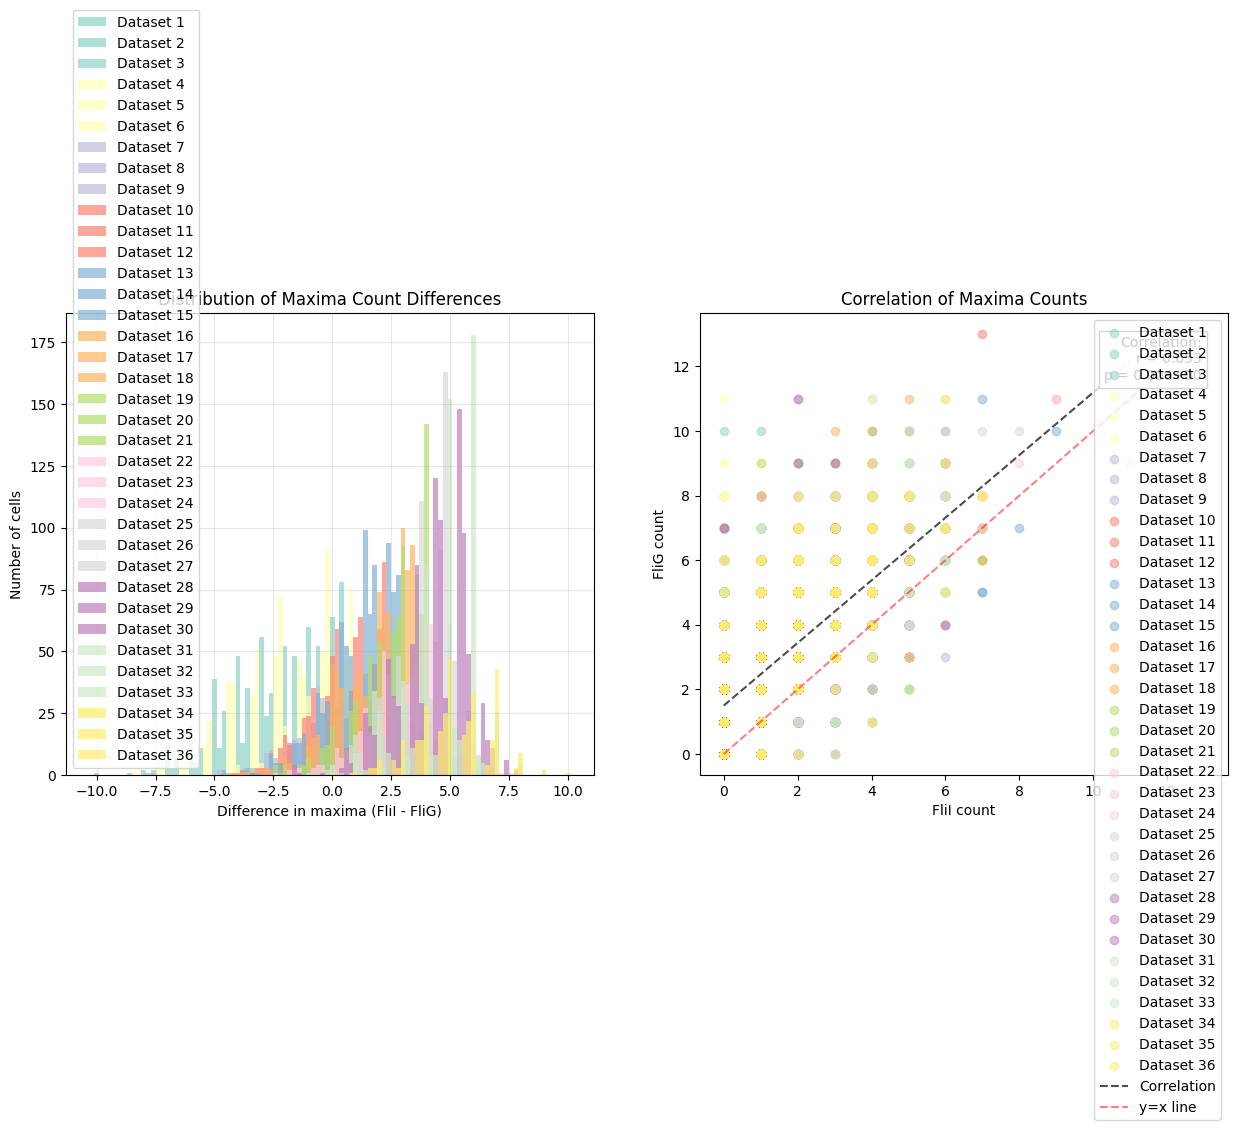

In [16]:
foci1_name="FliI"
foci2_name="FliG"

# Analyze and visualize the differences
all_stats = compare_maxima_between_foci_lists(
    il_results_c1, 
    il_results_c2,
    foci1_name=foci1_name,
    foci2_name=foci2_name
)

In [ ]:
"""
Notes:

Convert stats dictionary list to a pandas DataFrame table.

Parameters:
-----------
all_stats : list
    List of dictionaries containing statistics for each dataset
foci1_name : str, optional
    Name of first foci type for labeling
foci2_name : str, optional
    Name of second foci type for labeling
    
Returns:
--------
pd.DataFrame
    Table with datasets as columns and statistics as rows
"""

# Create dictionary with stats as rows and datasets as columns
table_dict = {
    f'Cells count in {foci1_name}': [],
    f'Cells count in {foci2_name}': [],
    'Cells with no foci': [],
    f'Cells with more {foci1_name}': [],
    f'Cells with more {foci2_name}': [],
    'Cells with equal counts': [],
    'Correlation coefficient': []
}

# Get column names (dataset labels)
columns = [stat['label'] for stat in all_stats]

# Fill in the values
for stat in all_stats:
    table_dict[f'Cells count in {foci1_name}'].append(stat['total_cells_array1'])
    table_dict[f'Cells count in {foci2_name}'].append(stat['total_cells_array2'])
    table_dict['Cells with no foci'].append(stat['no_foci_both'])
    table_dict[f'Cells with more {foci1_name}'].append(stat['more_foci1'])
    table_dict[f'Cells with more {foci2_name}'].append(stat['more_foci2'])
    table_dict['Cells with equal counts'].append(stat['equal_counts'])
    table_dict['Correlation coefficient'].append(round(stat['correlation'], 3))

# Create DataFrame
df = pd.DataFrame(table_dict, index=columns)

# Transpose to have datasets as columns
df = df.transpose()

print("\nStatistics Summary:")
df



Statistics Summary:


,Dataset 1,Dataset 2,Dataset 3,Dataset 4,Dataset 5,Dataset 6,Dataset 7,Dataset 8,Dataset 9,Dataset 10,...,Dataset 28,Dataset 29,Dataset 30,Dataset 31,Dataset 32,Dataset 33,Dataset 34,Dataset 35,Dataset 36,Total
Cells count in FliI,369.000,102.000,304.000,292.000,422.000,135.000,98.000,143.000,122.000,157.000,...,435.00,366.000,171.000,525.000,47.000,50.000,61.000,85.000,185.00,8456.000
Cells count in FliG,369.000,102.000,304.000,292.000,422.000,135.000,98.000,143.000,122.000,157.000,...,435.00,366.000,171.000,525.000,47.000,50.000,61.000,85.000,185.00,8456.000
Cells with no foci,51.000,14.000,66.000,34.000,60.000,16.000,7.000,21.000,10.000,25.000,...,86.00,53.000,31.000,106.000,2.000,0.000,2.000,8.000,16.00,1410.000
Cells with more FliI,15.000,3.000,11.000,9.000,13.000,11.000,7.000,10.000,11.000,8.000,...,35.00,14.000,13.000,32.000,1.000,0.000,0.000,3.000,12.00,486.000
Cells with more FliG,290.000,82.000,215.000,237.000,333.000,89.000,72.000,92.000,80.000,104.000,...,252.00,254.000,109.000,315.000,39.000,45.000,57.000,68.000,130.00,5538.000
Cells with equal counts,64.000,17.000,78.000,46.000,76.000,35.000,19.000,41.000,31.000,45.000,...,148.00,98.000,49.000,178.000,7.000,5.000,4.000,14.000,43.00,2432.000
Correlation coefficient,0.301,0.212,0.333,0.257,0.282,0.748,0.634,0.734,0.686,0.763,...,0.72,0.725,0.691,0.708,0.805,0.663,0.798,0.742,0.62,0.653


In [ ]:
save = False  # Set to False if you don't want to save

if save:
    output_path = "statistics_summary.xlsx"  # Relative path — same folder as notebook
    df.to_excel(output_path)
    print(f"\nTable saved to {output_path}")


Table saved to statistics_summary.xlsx


In [22]:
'''
Why num_data_list?

All data is in one folder including the segmentation data.

This data includes multiple data sets. num_data_list is the number of images in each data set.
'''

'\nWhy num_data_list?\n\nAll data is in one folder including the segmentation data.\n\nThis data includes multiple data sets. num_data_list is the number of images in each data set.\n'

Plot saved to: /Users/rosaeinenkel/Desktop/FliI_Analysis/colocalization_plot_1.png


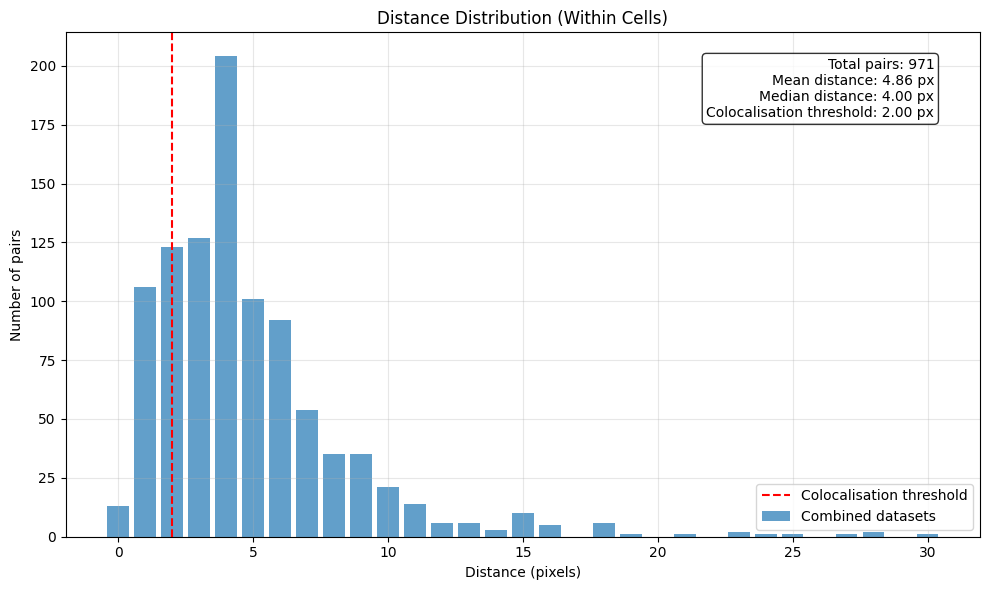

Plot saved to: /Users/rosaeinenkel/Desktop/FliI_Analysis/colocalization_plot_2.png


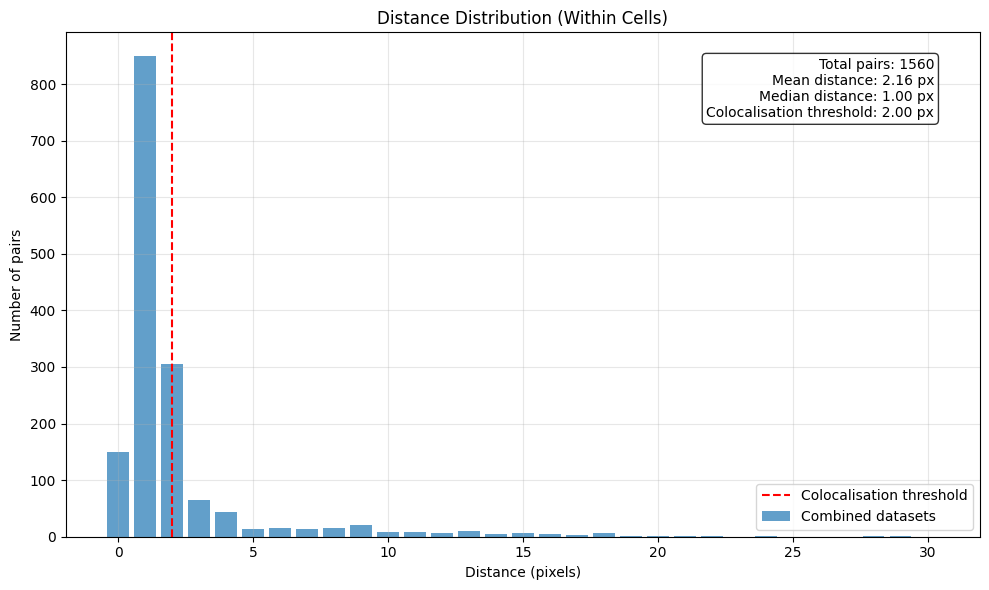

Plot saved to: /Users/rosaeinenkel/Desktop/FliI_Analysis/colocalization_plot_3.png


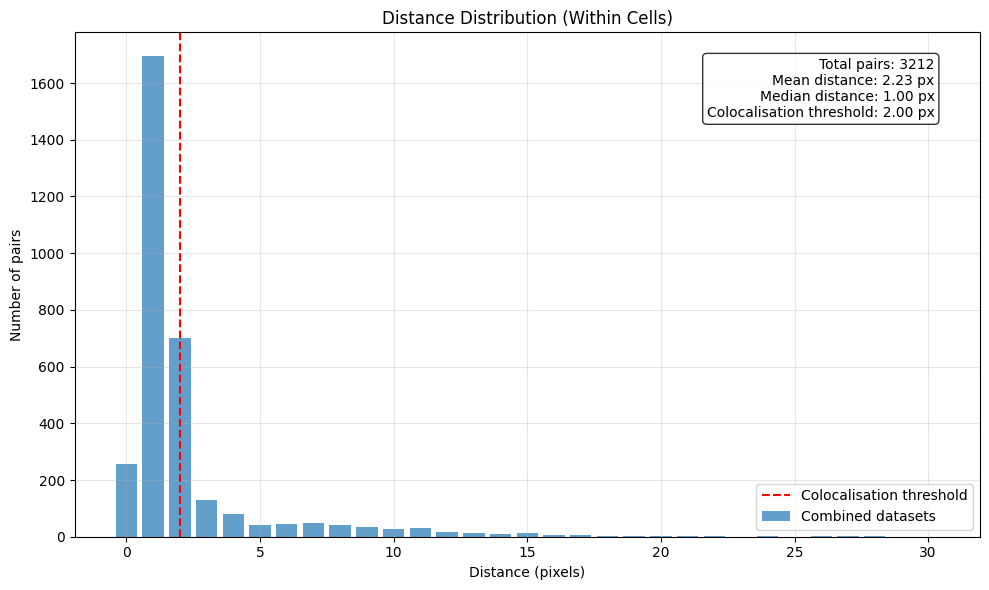

Plot saved to: /Users/rosaeinenkel/Desktop/FliI_Analysis/colocalization_plot_4.png


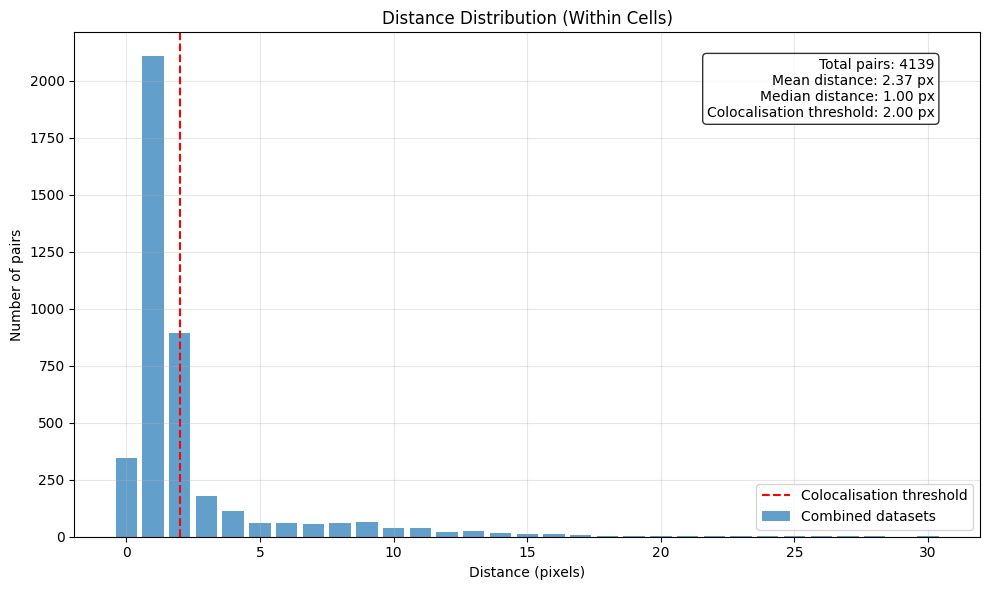

Plot saved to: /Users/rosaeinenkel/Desktop/FliI_Analysis/colocalization_plot_5.png


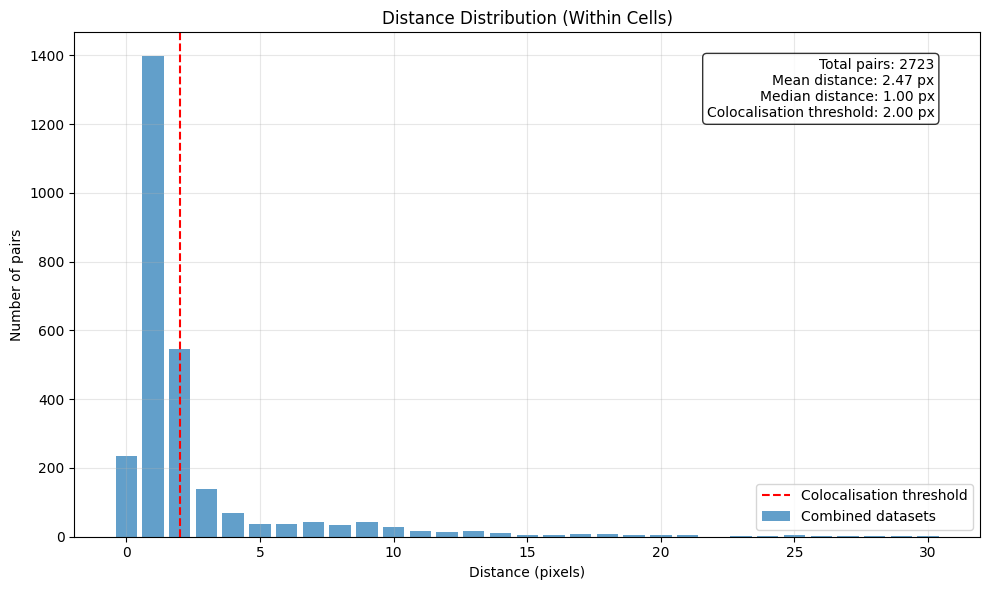

Plot saved to: /Users/rosaeinenkel/Desktop/FliI_Analysis/colocalization_plot_6.png


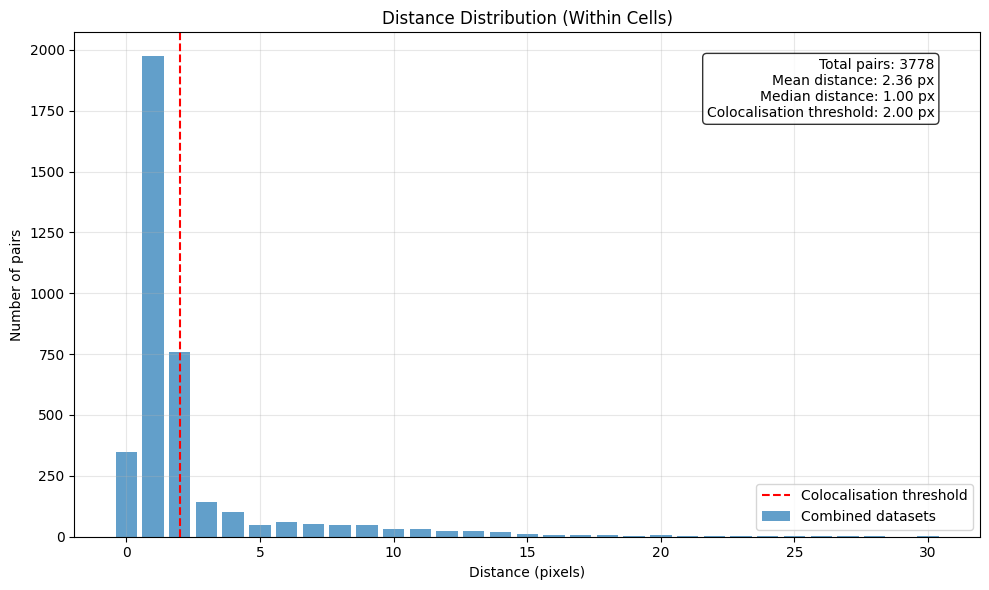

Plot saved to: /Users/rosaeinenkel/Desktop/FliI_Analysis/colocalization_plot_7.png


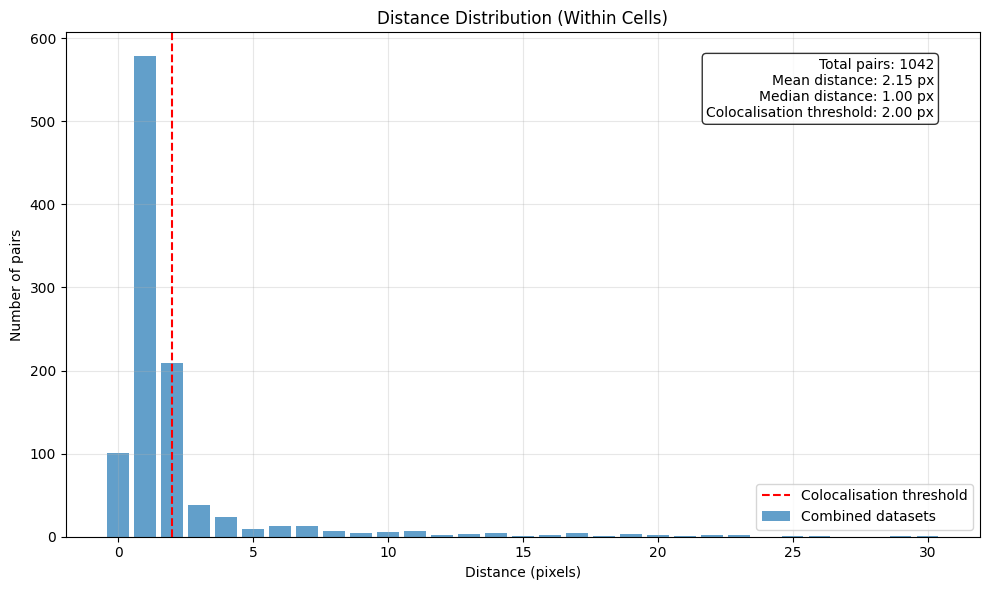

In [ ]:
from pathlib import Path

all_all = []
start_i = -num_data_list[0]  # dirty dirty dirty ...
end_i = 0

for i in range(len(num_data_list)):
    
    start_i += num_data_list[i-1]
    end_i = start_i + num_data_list[i]
    
    c1_d = il_maxima_coords_c1[start_i:end_i]
    c2_d = il_maxima_coords_c2[start_i:end_i]
    masks = labeled_mask_phase[start_i:end_i]
    
    # Optional: Set label for the current dataset
    label = f"Dataset_{i+1}"
    
    # Define unique filename for each plot
    plot_filename = f"colocalization_plot_{i+1}.png"
    
    all_stats = analyze_colocalization_lists(
        coords1_list=c1_d,
        coords2_list=c2_d,
        cell_masks=masks,
        max_distance=30,
        colocalisation_threshold=2,
        labels=[label]*len(c1_d),  # apply the same label to all in this group
        individual_idx=None,
        save_plot=0,
        plot_filename=plot_filename,
        title=title_list[i]
    )

    all_all.append(all_stats)

In [ ]:
# Create violin plot for colocalization distances

import seaborn as sns

# Prepare data for violin plot
violin_data = []
violin_labels = []

# Extract distance data from all_all
for i, group_stats in enumerate(all_all):
    # Get all distances from this group
    group_distances = []
    for stat in group_stats:
        # Get all distances (both valid and invalid)
        all_distances = np.concatenate([stat['valid_distances'], stat['invalid_distances']])
        group_distances.extend(all_distances)
    
    # Filter distances up to max_distance=30
    group_distances = np.array(group_distances)
    group_distances = group_distances[group_distances <= 30]
    
    violin_data.append(group_distances)
    violin_labels.append(title_list[i])

# Create the violin plot
plt.figure(figsize=(12, 8))

# Create violin plot
parts = plt.violinplot(violin_data, positions=range(len(violin_labels)), 
                      showmeans=True, showmedians=True, widths=0.8)

# parts = plt.boxplot(violin_data, labels=violin_labels, patch_artist=True, 
#                       showmeans=True, meanline=True, widths=0.6)

# Customize violin plot colors
colors = plt.cm.Set3(np.linspace(0, 1, len(violin_labels)))
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

# Add horizontal dotted line for colocalisation threshold
plt.axhline(y=2, color='red', linestyle='--', linewidth=2, 
           label='Colocalisation threshold (2 px)', alpha=0.8)

# Customize the plot
plt.xlabel('Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Distance (nm)', fontsize=12, fontweight='bold')
plt.title('Colocalization Distance Distribution by Dataset', fontsize=14, fontweight='bold')

# Set x-axis labels
plt.xticks(range(len(violin_labels)), violin_labels, rotation=45, ha='right')

# Add grid for better readability
plt.grid(True, alpha=0.3, axis='y')

# Add legend
plt.legend(loc='upper right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics for each dataset
print("\nSummary Statistics:")
print("=" * 50)
for i, (label, distances) in enumerate(zip(violin_labels, violin_data)):
    if len(distances) > 0:
        print(f"{label}:")
        print(f"  Count: {len(distances)}")
        print(f"  Mean: {np.mean(distances):.2f} px")
        print(f"  Median: {np.median(distances):.2f} px")
        print(f"  Std: {np.std(distances):.2f} px")
        print(f"  Min: {np.min(distances):.2f} px")
        print(f"  Max: {np.max(distances):.2f} px")
        print(f"  % ≤ 2px: {np.sum(distances <= 2) / len(distances) * 100:.1f}%")
        print(f"  % > 2px: {np.sum(distances > 2) / len(distances) * 100:.1f}%")
        print()
    else:
        print(f"{label}: No data")
        print()

In [ ]:
# Group the datasets according to num_data_list
dataset_groups = []
start_i = 0
for i, group_size in enumerate(num_data_list):
    end_i = start_i + group_size
    
    # Get the maxima count data for this group
    group_flii_data = il_results_c1[start_i:end_i]
    group_flig_data = il_results_c2[start_i:end_i]
    
    # Get the raw coordinates and masks for this group
    group_flii_coords = il_maxima_coords_c1[start_i:end_i]
    group_flig_coords = il_maxima_coords_c2[start_i:end_i]
    group_masks = labeled_mask_phase[start_i:end_i]
    
    group_data = {
        'group_idx': i,
        'start_idx': start_i,
        'end_idx': end_i,
        'flii_results': group_flii_data,
        'flig_results': group_flig_data,
        'flii_coords': group_flii_coords,
        'flig_coords': group_flig_coords,
        'masks': group_masks
    }
    dataset_groups.append(group_data)
    start_i = end_i

# Create histograms for each group
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for group_idx, group_data in enumerate(dataset_groups):
    ax = axes[group_idx]
    
    # Extract maxima counts for FliI and FliG
    flii_counts = []
    flig_counts = []
    
    for dataset in group_data['flii_results']:
        if isinstance(dataset, np.ndarray) and dataset.ndim == 2 and dataset.shape[1] > 1:
            flii_counts.extend(dataset[:, 1])  # Second column contains counts
    
    for dataset in group_data['flig_results']:
        if isinstance(dataset, np.ndarray) and dataset.ndim == 2 and dataset.shape[1] > 1:
            flig_counts.extend(dataset[:, 1])  # Second column contains counts
    
    # Create histogram
    if flii_counts or flig_counts:
        max_count = max(max(flii_counts) if flii_counts else 0, 
                       max(flig_counts) if flig_counts else 0)
        bins = np.arange(0, max_count + 2) - 0.5
        
        ax.hist([flii_counts, flig_counts], bins=bins, 
                label=['FliI', 'FliG'], alpha=0.7, 
                color=['red', 'blue'], edgecolor='black')
        
        ax.set_xlabel('Maxima per Cell')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Group {group_idx + 1} (Datasets {group_data["start_idx"]+1}-{group_data["end_idx"]})')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        if flii_counts:
            ax.text(0.02, 0.98, f'FliI: μ={np.mean(flii_counts):.1f}, σ={np.std(flii_counts):.1f}', 
                   transform=ax.transAxes, verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
        if flig_counts:
            ax.text(0.02, 0.90, f'FliG: μ={np.mean(flig_counts):.1f}, σ={np.std(flig_counts):.1f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='blue', alpha=0.3))
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Group {group_idx + 1}')

plt.tight_layout()
plt.show()

# Create summary table for each group
group_summaries = []

for group_data in dataset_groups:
    flii_counts = []
    flig_counts = []
    cell_counts = []
    
    # Collect data from all datasets in this group
    for res_c1, res_c2 in zip(group_data['flii_results'], group_data['flig_results']):
        if (isinstance(res_c1, np.ndarray) and res_c1.ndim == 2 and res_c1.shape[1] > 1 and
            isinstance(res_c2, np.ndarray) and res_c2.ndim == 2 and res_c2.shape[1] > 1):
            
            flii_counts.extend(res_c1[:, 1])  # Second column contains counts
            flig_counts.extend(res_c2[:, 1])  # Second column contains counts
            cell_counts.append(len(res_c1))
    
    # Calculate statistics
    if flii_counts and flig_counts:
        summary = {
            'Group': f'Group {group_data["group_idx"] + 1}',
            'Datasets': f'{group_data["start_idx"]+1}-{group_data["end_idx"]}',
            'Total_Cells': sum(cell_counts),
            'FliI_Total': sum(flii_counts),
            'FliG_Total': sum(flig_counts),
            'FliI_Mean': np.mean(flii_counts),
            'FliI_Std': np.std(flii_counts),
            'FliI_Min': np.min(flii_counts),
            'FliI_Max': np.max(flii_counts),
            'FliG_Mean': np.mean(flig_counts),
            'FliG_Std': np.std(flig_counts),
            'FliG_Min': np.min(flig_counts),
            'FliG_Max': np.max(flig_counts),
            'FliI_per_Cell': sum(flii_counts) / sum(cell_counts) if sum(cell_counts) > 0 else 0,
            'FliG_per_Cell': sum(flig_counts) / sum(cell_counts) if sum(cell_counts) > 0 else 0
        }
        group_summaries.append(summary)

# Create DataFrame and display
df_summary = pd.DataFrame(group_summaries)

# Display the summary table
print("Summary Statistics by Group:")
print("=" * 100)
print(df_summary.to_string(index=False, float_format='%.2f'))

# Create a more detailed table with individual dataset information
print("\n" + "=" * 100)
print("Detailed Dataset Information by Group:")
print("=" * 100)

for group_data in dataset_groups:
    print(f"\nGroup {group_data['group_idx'] + 1} (Datasets {group_data['start_idx']+1}-{group_data['end_idx']}):")
    print("-" * 80)
    print("Dataset\t|\tFliI\t|\tFliG\t|\tCells\t|\tFliI/Cell\t|\tFliG/Cell")
    print("-" * 80)
    
    group_flii_total = 0
    group_flig_total = 0
    group_cells_total = 0
    
    for i, (res_c1, res_c2) in enumerate(zip(group_data['flii_results'], group_data['flig_results'])):
        dataset_idx = group_data['start_idx'] + i
        
        if (isinstance(res_c1, np.ndarray) and res_c1.ndim == 2 and res_c1.shape[1] > 1 and
            isinstance(res_c2, np.ndarray) and res_c2.ndim == 2 and res_c2.shape[1] > 1):
            
            flii_cnt = np.sum(res_c1[:, 1])
            flig_cnt = np.sum(res_c2[:, 1])
            cell_cnt = len(res_c1)
            
            flii_per_cell = flii_cnt / cell_cnt if cell_cnt > 0 else 0
            flig_per_cell = flig_cnt / cell_cnt if cell_cnt > 0 else 0
            
            print(f"{dataset_idx + 1}\t|\t{flii_cnt}\t|\t{flig_cnt}\t|\t{cell_cnt}\t|\t{flii_per_cell:.2f}\t|\t{flig_per_cell:.2f}")
            
            group_flii_total += flii_cnt
            group_flig_total += flig_cnt
            group_cells_total += cell_cnt
    
    # Group totals
    group_flii_per_cell = group_flii_total / group_cells_total if group_cells_total > 0 else 0
    group_flig_per_cell = group_flig_total / group_cells_total if group_cells_total > 0 else 0
    print("-" * 80)
    print(f"TOTAL\t|\t{group_flii_total}\t|\t{group_flig_total}\t|\t{group_cells_total}\t|\t{group_flii_per_cell:.2f}\t|\t{group_flig_per_cell:.2f}")

# Overall totals across all groups
print("\n" + "=" * 100)
print("OVERALL TOTALS:")
print("=" * 100)
print(f"Total FliI maxima: {total_FliI_cnt}")
print(f"Total FliG maxima: {total_FliG_cnt}")
print(f"Total cells: {total_cell_cnt}")
print(f"Overall FliI per cell: {total_FliI_cnt / total_cell_cnt:.2f}")
print(f"Overall FliG per cell: {total_FliG_cnt / total_cell_cnt:.2f}")

In [31]:
strain_names = [f"Strain {i+1}" for i in range(len(all_all))]

for name, group_stats in zip(strain_names, all_all):
    total_pairs = sum(stat['total_pairs'] for stat in group_stats)
    valid_pairs = sum(len(stat['valid_pairs']) for stat in group_stats)
    ratio = valid_pairs / total_pairs if total_pairs > 0 else 0
    print(f"{name}: Total = {total_pairs}, Valid = {valid_pairs}, Ratio = {ratio:.4f}")

Strain 1: Total = 971, Valid = 157, Ratio = 0.1617
Strain 2: Total = 1560, Valid = 1146, Ratio = 0.7346
Strain 3: Total = 3212, Valid = 2327, Ratio = 0.7245
Strain 4: Total = 4139, Valid = 2910, Ratio = 0.7031
Strain 5: Total = 2723, Valid = 1923, Ratio = 0.7062
Strain 6: Total = 3778, Valid = 2722, Ratio = 0.7205
Strain 7: Total = 1042, Valid = 788, Ratio = 0.7562


In [ ]:
summary_data = []

for name, group_stats in zip(strain_names, all_all):
    total_pairs = sum(stat['total_pairs'] for stat in group_stats)
    valid_pairs = sum(len(stat['valid_pairs']) for stat in group_stats)
    ratio = valid_pairs / total_pairs if total_pairs > 0 else 0

    summary_data.append({
        'Strain': name,
        'Total Pairs': total_pairs,
        'Valid Pairs': valid_pairs,
        'Ratio': round(ratio, 4)
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Print
print("\nColocalization Summary:")
print(summary_df)

# Save to Excel or CSV
save_summary = False
if save_summary:
    output_path = Path.cwd() / "colocalization_summary.xlsx"  # or use .csv if preferred
    summary_df.to_excel(output_path, index=False)
    print(f"\nSummary table saved to: {output_path}")


Colocalization Summary:
     Strain  Total Pairs  Valid Pairs   Ratio
0  Strain 1          971          157  0.1617
1  Strain 2         1560         1146  0.7346
2  Strain 3         3212         2327  0.7245
3  Strain 4         4139         2910  0.7031
4  Strain 5         2723         1923  0.7062
5  Strain 6         3778         2722  0.7205
6  Strain 7         1042          788  0.7562

Summary table saved to: /Users/rosaeinenkel/Desktop/FliI_Analysis/colocalization_summary.xlsx
